#DSA4264

## Reading in Data & Importing Lib

### Set up Dir

In [3]:
import sys, os
if 'google.colab' in sys.modules:

    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/School stuff/Y4 S1/DSA4264'

    # move to Google Drive directory
    os.chdir(path_to_file)

Mounted at /content/gdrive


### Install Packages

### Import Lib

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go

import re,nltk
import string
import gensim

from transformers import AutoTokenizer
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from plotly.subplots import make_subplots

### Downloads

### Read in Data

In [5]:
Data1 = pd.read_csv('./data/Data_1.csv', engine = 'python')
Data2 = pd.read_csv('./data/Data_2.csv', engine = 'python')
Data3 = pd.read_csv('./data/Data_3.csv', engine = 'python')
Data4 = pd.read_csv('./data/Data_4.csv', engine = 'python')
Data5 = pd.read_csv('./data/Data_5.csv', engine = 'python')
Data6 = pd.read_csv('./data/Data_6.csv', engine = 'python')
Data7 = pd.read_csv('./data/Data_7.csv', engine = 'python')

### Merge Data

In [6]:
Data = pd.concat([Data1, Data2, Data3, Data4, Data5, Data6, Data7], ignore_index=True, axis=0)

Data = Data.drop(columns=['Unnamed: 0'])

In [7]:
del Data1, Data2, Data3, Data4, Data5, Data6, Data7

### Datatypes

In [8]:
Data['timestamp']= pd.to_datetime(Data['timestamp'])
Data['post_timestamp']= pd.to_datetime(Data['timestamp'])

## Subreddit Rules

|r/Singapore|r/SingaporeRaw|r/SingaporeHappenings|
|-----|-----|-----|
|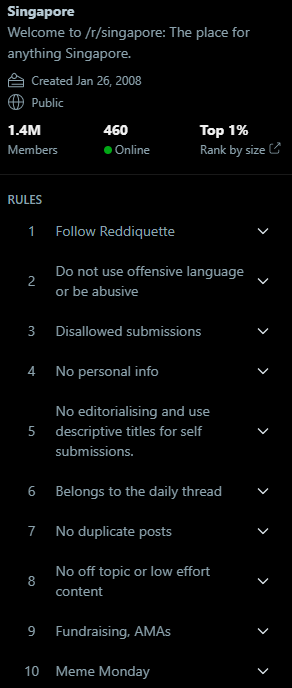|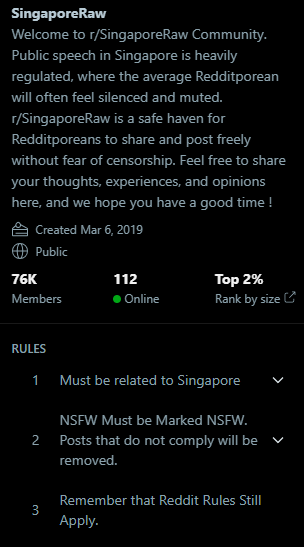|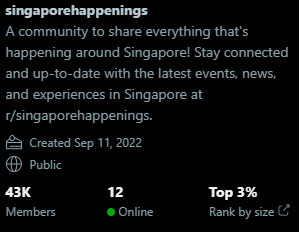|

## Analysis

### General Proportion of Hate Comments


In [27]:
subreddit = Data.groupby('subreddit').agg(
    total_post=('post_title', 'nunique'),
    total_text=('text', 'count'),
    total_hate=('BERT_2_hate', 'sum')
).reset_index()

subreddit['text_per_post'] = subreddit['total_text']/subreddit['total_post']
subreddit['hate_per_text'] = subreddit['total_hate']/subreddit['total_text']
subreddit['hate_per_post'] = subreddit['total_hate']/subreddit['total_post']
subreddit = subreddit.sort_values(by='total_text', ascending=False)

subreddit

,subreddit,total_post,total_text,total_hate,text_per_post,hate_per_text,hate_per_post
0,r/Singapore,78028,3906558,1310841,50.066104,0.335549,16.799623
2,r/SingaporeRaw,15398,347622,161401,22.575789,0.464300,10.481946
1,r/SingaporeHappenings,1226,46377,23860,37.827896,0.514479,19.461664


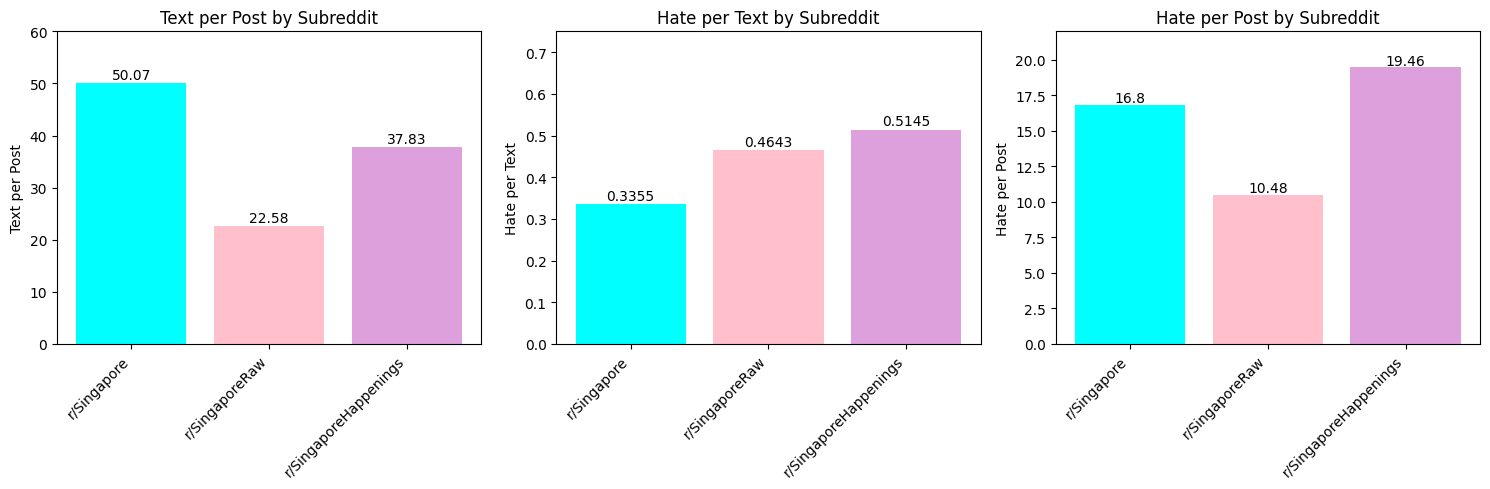

In [31]:
subreddit_names = subreddit['subreddit'].tolist()
text_per_post = subreddit['text_per_post'].tolist()
hate_per_text = subreddit['hate_per_text'].tolist()
hate_per_post = subreddit['hate_per_post'].tolist()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define colors for each subreddit
colors = ['cyan', 'pink', 'plum']

# Plot text_per_post
x = np.arange(len(subreddit_names))
axs[0].bar(x, text_per_post, color=colors)
axs[0].set_xticks(x)
axs[0].set_xticklabels(subreddit_names, rotation=45, ha='right')
axs[0].set_ylabel('Text per Post')
axs[0].set_title('Text per Post by Subreddit')
axs[0].set_ylim(0,60)

for i, v in enumerate(text_per_post):
    axs[0].text(i, v + 0.75, str(round(v, 2)), ha='center')

# Plot hate_per_text
axs[1].bar(x, hate_per_text, color=colors)
axs[1].set_xticks(x)
axs[1].set_xticklabels(subreddit_names, rotation=45, ha='right')
axs[1].set_ylabel('Hate per Text')
axs[1].set_title('Hate per Text by Subreddit')
axs[1].set_ylim(0,0.75)

for i, v in enumerate(hate_per_text):
    axs[1].text(i, v + 0.01, str(round(v, 4)), ha='center')

# Plot hate_per_post
axs[2].bar(x, hate_per_post, color=colors)
axs[2].set_xticks(x)
axs[2].set_xticklabels(subreddit_names, rotation=45, ha='right')
axs[2].set_ylabel('Hate per Post')
axs[2].set_title('Hate per Post by Subreddit')
axs[2].set_ylim(0,22)

for i, v in enumerate(hate_per_post):
    axs[2].text(i, v + 0.2, str(round(v, 2)), ha='center')

plt.tight_layout()
plt.show()

Sg has the most post & comments
Sg has the most comments PER post followed by Sg Raw then SG happenings
SG has the least toxic comments per comments
Sg has the 2nd most toxic comments per post



### Monthly Post & Comment Overview

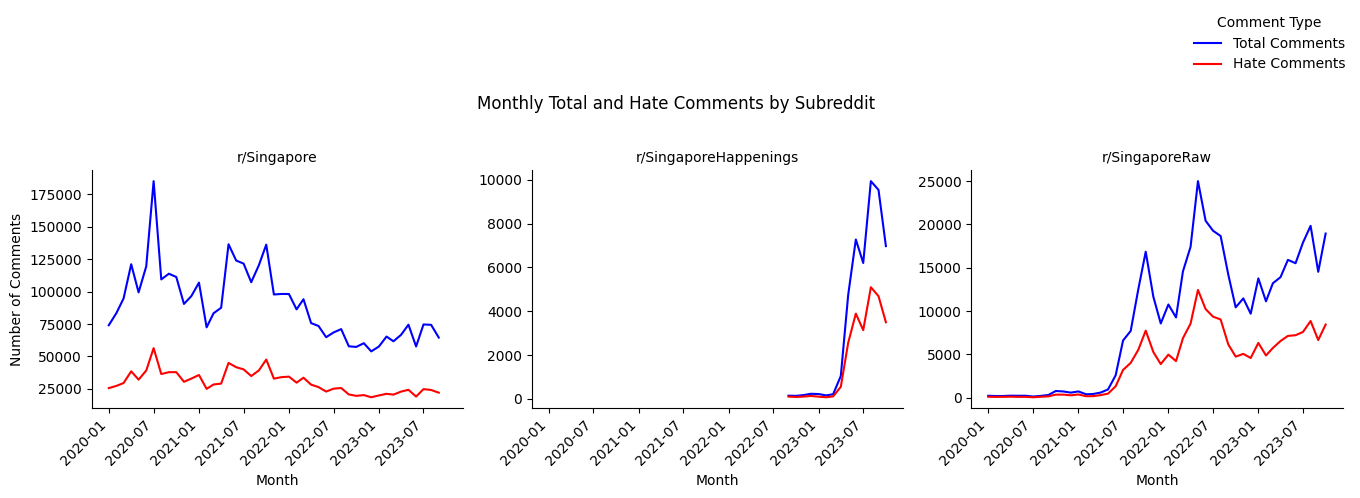

In [17]:
# Create a month column
Data['month'] = Data['timestamp'].dt.to_period('M')

# Count total comments
total_comments_counts = Data.groupby(['subreddit', 'month']).size().reset_index(name='total_comments')

# Filter for hate comments and count
hate_comments_counts = Data[Data['BERT_2_hate'] == True].groupby(['subreddit', 'month']).size().reset_index(name='hate_comments')

# Merge the two DataFrames on subreddit and month
monthly_counts = pd.merge(total_comments_counts, hate_comments_counts, on=['subreddit', 'month'], how='left')

# Fill NaN values in hate_comments with 0 (for subreddits with no hate comments)
monthly_counts['hate_comments'] = monthly_counts['hate_comments'].fillna(0)

# Convert the month back to datetime for plotting purposes
monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()

# Set up the Seaborn FacetGrid for plotting side by side
g = sns.FacetGrid(monthly_counts, col="subreddit", height=4, sharey=False)

# Map the lineplot onto the grid for total comments
g.map_dataframe(sns.lineplot, x='month', y='total_comments', label='Total Comments', color='blue')

# Map the lineplot onto the grid for hate comments
g.map_dataframe(sns.lineplot, x='month', y='hate_comments', label='Hate Comments', color='red')

# Add the legend in the top right corner
g.add_legend(title='Comment Type', bbox_to_anchor=(1, 1.25), loc='upper right')

# Set axis labels and title
g.set_axis_labels("Month", "Number of Comments")
g.set_titles("{col_name}")
g.fig.suptitle("Monthly Total and Hate Comments by Subreddit", y=1.02)

# Rotate x-axis labels for each subplot
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


In [18]:
# Create a month column
Data['month'] = Data['timestamp'].dt.to_period('M')

# Count total comments
total_comments_counts = Data.groupby(['subreddit', 'month']).size().reset_index(name='total_comments')

# Filter for hate comments and count
hate_comments_counts = Data[Data['BERT_2_hate'] == True].groupby(['subreddit', 'month']).size().reset_index(name='hate_comments')

# Merge the two DataFrames on subreddit and month
monthly_counts = pd.merge(total_comments_counts, hate_comments_counts, on=['subreddit', 'month'], how='left')

# Fill NaN values in hate_comments with 0 (for subreddits with no hate comments)
monthly_counts['hate_comments'] = monthly_counts['hate_comments'].fillna(0)

# Convert the month back to datetime for plotting purposes
monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()

# Melt the DataFrame to have total and hate comments in a single 'Comment Type' column
monthly_counts_melted = monthly_counts.melt(
    id_vars=['subreddit', 'month'],
    value_vars=['total_comments', 'hate_comments'],
    var_name='Comment Type',
    value_name='Count'
)

# Create an interactive line plot with Plotly Express
fig = px.line(
    monthly_counts_melted,
    x='month',
    y='Count',
    color='Comment Type',
    facet_col='subreddit',
    title="Monthly Total and Hate Comments by Subreddit",
    labels={"month": "Month", "Count": "Number of Comments"},
    height=500,
    facet_col_wrap=None  # Set to None to display horizontally
)

# Update layout to improve readability
fig.update_layout(
    legend=dict(title='Comment Type', x=1.02, y=1),
    title_x=0.5
)

# Update x-axis ticks to rotate for readability
fig.update_xaxes(tickangle=45)

# Show interactive plot
fig.show()


FYI, SG Happenings was created in Sept 2022

In [19]:
# Create a month column
Data['month'] = Data['timestamp'].dt.to_period('M')

# Aggregate the data - Count number of unique posts per subreddit per month
posts_count = Data.groupby(['subreddit', 'month'])['post_id'].nunique().reset_index(name='num_posts')

# Count total comments per subreddit per month
comments_count = Data.groupby(['subreddit', 'month']).size().reset_index(name='total_comments')

# Count hate comments per subreddit per month
hate_comments_count = Data[Data['BERT_2_hate'] == True].groupby(['subreddit', 'month']).size().reset_index(name='hate_comments')

# Merge all counts into a single DataFrame
monthly_counts = posts_count.merge(comments_count, on=['subreddit', 'month'], how='left')
monthly_counts = monthly_counts.merge(hate_comments_count, on=['subreddit', 'month'], how='left')
monthly_counts['hate_comments'] = monthly_counts['hate_comments'].fillna(0)

# Convert 'month' back to datetime for plotting
monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()

# Set up the Plotly subplots and define a color palette
subreddits = monthly_counts['subreddit'].unique()
color_palette = px.colors.qualitative.Plotly  # Choose a color palette from Plotly

# Create a dictionary to map each subreddit to a unique color
subreddit_colors = {sub: color_palette[i % len(color_palette)] for i, sub in enumerate(subreddits)}

fig = make_subplots(rows=1, cols=3, subplot_titles=('Number of Posts', 'Total Comments', 'Hate Comments'))

# Add traces for each subplot, using the standardized colors for each subreddit
for subreddit in subreddits:
    subreddit_data = monthly_counts[monthly_counts['subreddit'] == subreddit]

    # Plot for number of posts
    fig.add_trace(go.Scatter(x=subreddit_data['month'], y=subreddit_data['num_posts'],
                             mode='lines+markers', name=subreddit,
                             line=dict(color=subreddit_colors[subreddit])), row=1, col=1)

    # Plot for total comments
    fig.add_trace(go.Scatter(x=subreddit_data['month'], y=subreddit_data['total_comments'],
                             mode='lines+markers', showlegend=False,
                             line=dict(color=subreddit_colors[subreddit])), row=1, col=2)

    # Plot for hate comments
    fig.add_trace(go.Scatter(x=subreddit_data['month'], y=subreddit_data['hate_comments'],
                             mode='lines+markers', showlegend=False,
                             line=dict(color=subreddit_colors[subreddit])), row=1, col=3)

# Update layout and set interactive
fig.update_layout(
    title='Monthly Number of Posts, Total Comments, and Hate Comments by Subreddit',
    xaxis_title='Month',
    yaxis_title='Count',
    hovermode='x unified',
    height=600,
    showlegend=True
)

# Rotate x-axis labels for better readability
fig.update_xaxes(tickangle=45)

# Display the plot
fig.show()


### Post with highest Proportion of Hate Comments

In [20]:
# Filter out rows where post_title is '[deleted by user]'
Data = Data[Data['post_title'] != '[deleted by user]']

# Filter for hate comments
hate_comments = Data[Data['BERT_2_hate'] == True]

# Group by post_id and subreddit to count hate comments and total comments
post_comment_counts = Data.groupby(['post_id', 'subreddit']).agg(
    total_comments=('text', 'size'),
    hate_comment_count=('BERT_2_hate', lambda x: x.sum())
).reset_index()

# Calculate percentage of hate comments
post_comment_counts['hate_percentage'] = (post_comment_counts['hate_comment_count'] / post_comment_counts['total_comments']) * 100

# Sort and get top 100 posts for each subreddit based on hate percentage
top_posts = post_comment_counts.sort_values(['subreddit', 'hate_percentage'], ascending=[True, False])

# Step 6: Get the top 100 posts for each subreddit
top_100_posts = top_posts.groupby('subreddit').head(100)

# Step 7: Merge back to get the post titles
top_100_posts = top_100_posts.merge(Data[['post_id', 'post_title']], on='post_id', how='left')

# Step 8: Remove duplicates based on 'subreddit' and 'post_title'
top_100_posts = top_100_posts.drop_duplicates(subset=['subreddit', 'post_title'])

# Display the result
top_100_posts[['subreddit', 'post_title', 'hate_percentage']]

,subreddit,post_title,hate_percentage
0,r/Singapore,Number of dengue cases in 2022 likely to be se...,100.0
1,r/Singapore,"F4M (23) I'm available for hookup,ft and conte...",100.0
2,r/Singapore,CDC voucher redemption website temporarily dow...,100.0
3,r/Singapore,Singapore’s hospices extend support for more i...,100.0
5,r/Singapore,Join our study on atherosclerotic cardiovascul...,100.0
...,...,...,...
525,r/SingaporeRaw,Do you guys feel bus commuters are generally m...,100.0
528,r/SingaporeRaw,feminists have created a culture and a system ...,100.0
534,r/SingaporeRaw,https://www.theonlinecitizen.com/2023/05/16/we...,100.0
536,r/SingaporeRaw,Low SES people fighting on the cruise,100.0


## Posts with most toxic Comments

Remove r/Singapore Random discussion & small qn thread

In [32]:
# Filter for toxic comments
toxic_comments = Data[Data['BERT_2_hate'] == True]

# Exclude specific post_titles for r/Singapore
# Change: Use 'fillna(False)' to replace NaN with False before applying ~
exclude_condition = Data['post_title'].str.startswith('/r/singapore random discussion and small questions thread for').fillna(False)
Data_filtered = Data[~(Data['subreddit'] == 'r/Singapore') | ~exclude_condition]

# Group by post_id and subreddit to count toxic comments
post_toxic_counts = toxic_comments.groupby(['post_id', 'subreddit']).size().reset_index(name='toxic_comment_count')

# Sort and get top 100 posts for each subreddit
top_posts = post_toxic_counts.sort_values(['subreddit', 'toxic_comment_count'], ascending=[True, False])

# Get the top 100 posts for each subreddit
top_100_posts = top_posts.groupby('subreddit').head(100)

# Merge back to get the post titles and RAKE keywords
top_100_posts = top_100_posts.merge(Data[['post_id', 'post_title', 'rake_keywords']], on='post_id', how='left')

# Remove duplicates based on 'subreddit' and 'post_title'
top_100_posts = top_100_posts.drop_duplicates(subset=['subreddit', 'post_title'])

# Final filtering to exclude specific post titles for r/Singapore
top_100_posts = top_100_posts[~((top_100_posts['subreddit'] == 'r/Singapore') &
                                  (top_100_posts['post_title'].str.startswith('/r/singapore random discussion and small questions thread for')))]

# Display the result
top_100_posts[['subreddit', 'post_title', 'rake_keywords', 'toxic_comment_count']]


<ipython-input-32-e9efa439901f>:6: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,subreddit,post_title,rake_keywords,toxic_comment_count
0,r/Singapore,Singapore General Elections 2020 Polling Resul...,['general elections polling results live threa...,3320
82149,r/Singapore,I’m so sick of it,"['sick', 'im']",626
110461,r/Singapore,Someone is attacked on MRT.,"['someone', 'mrt', 'attacked']",584
113258,r/Singapore,"No dining in, social group sizes cut to 2 from...","['social group sizes cut', 'returns', 'phase',...",581
131672,r/Singapore,Don't pick fights with people bigger than you,"['dont pick fights', 'people bigger']",570
...,...,...,...,...
229921,r/SingaporeRaw,Another girl catches guy taking pics,['another girl catches guy taking pics'],105
230088,r/SingaporeRaw,Gender Inequality Index shows Singapore is in ...,"['gender inequality index shows', 'women want'...",105
230229,r/SingaporeRaw,Foreign worker involved in activism puzzled ab...,"['foreign worker involved', 'work permit', 'ac...",105
230463,r/SingaporeRaw,ST Opinion Piece: “Section 377A: Putting child...,"['st opinion piece section', 'putting children...",105


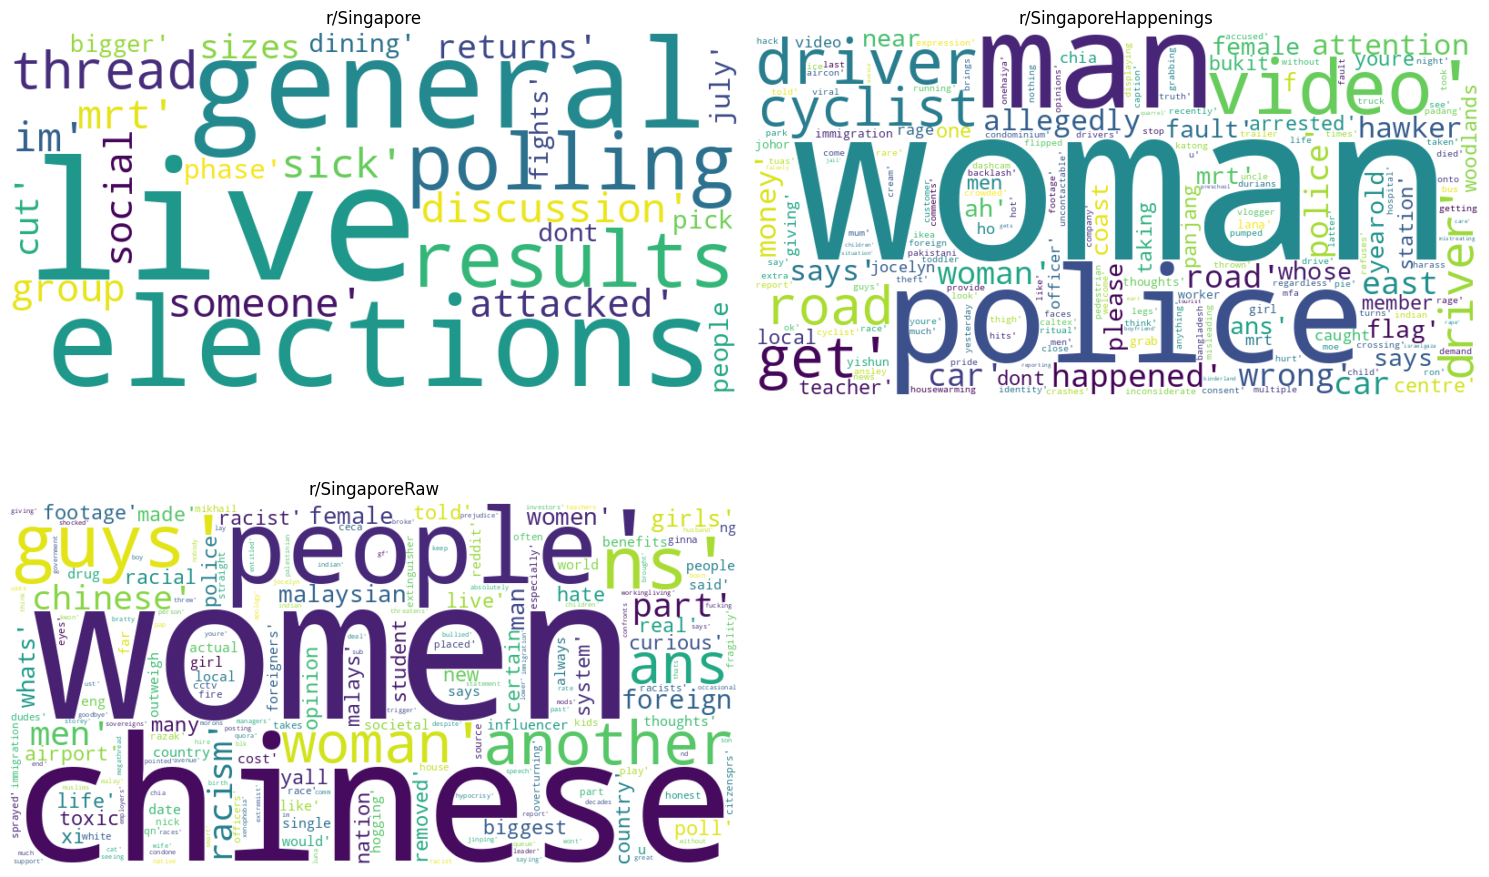

In [22]:
# Prepare Data by combining RAKE keywords for each subreddit
# Split the rake_keywords by comma and join them into a single string for each subreddit
top_100_posts['rake_keywords'] = top_100_posts['rake_keywords'].fillna('')  # Handle NaN values
subreddit_keywords = top_100_posts.groupby('subreddit')['rake_keywords'].apply(lambda x: ' '.join(x)).reset_index()

# Generate and plot word clouds for each subreddit
plt.figure(figsize=(15, 10))

for i, row in subreddit_keywords.iterrows():
    subreddit = row['subreddit']
    keywords = row['rake_keywords']

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(keywords)

    # Plotting
    plt.subplot(2, 2, i + 1)  # Adjust this according to the number of subreddits
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.title(subreddit)

plt.tight_layout()
plt.show()


## Most toxic users

Removed [deleted] & sneakpeek_bot

In [23]:
# Filter for hate comments and remove deleted usernames
hate_comments = Data[(Data['BERT_2_hate'] == True) & (Data['username'] != '[deleted]') & (Data['post_title'] != 'sneakpeek_bot')]

# Group by subreddit and username, counting the number of hate comments
hate_counts = hate_comments.groupby(['subreddit', 'username']).size().reset_index(name='hate_comment_count')

# Calculate total hate comments per subreddit
total_hate_per_subreddit = hate_counts.groupby('subreddit')['hate_comment_count'].sum().reset_index(name='total_hate_comments')

# Merge to get total hate comments alongside username hate comment count
hate_counts = hate_counts.merge(total_hate_per_subreddit, on='subreddit')

# Calculate percentage of hate comments
hate_counts['hate_percentage'] = (hate_counts['hate_comment_count'] / hate_counts['total_hate_comments']) * 100

# Get the top 100 usernames for each subreddit
top_hate_users = hate_counts.sort_values(['subreddit', 'hate_comment_count'], ascending=[True, False]).groupby('subreddit').head(100)

# Display the result
top_hate_users

,subreddit,username,hate_comment_count,total_hate_comments,hate_percentage
32782,r/Singapore,deangsana,9155,1258897,0.727224
29663,r/Singapore,blackwoodsix,8992,1258897,0.714276
8445,r/Singapore,FitCranberry,8376,1258897,0.665344
53357,r/Singapore,tom-slacker,7987,1258897,0.634444
14469,r/Singapore,MangoDangoLango,7206,1258897,0.572406
...,...,...,...,...,...
66373,r/SingaporeRaw,ComprehensiveLeg9523,205,156210,0.131234
69973,r/SingaporeRaw,Mindless_Archer_6410,204,156210,0.130593
69710,r/SingaporeRaw,Maleficent-Green3829,203,156210,0.129953
76527,r/SingaporeRaw,harvey_91,202,156210,0.129313


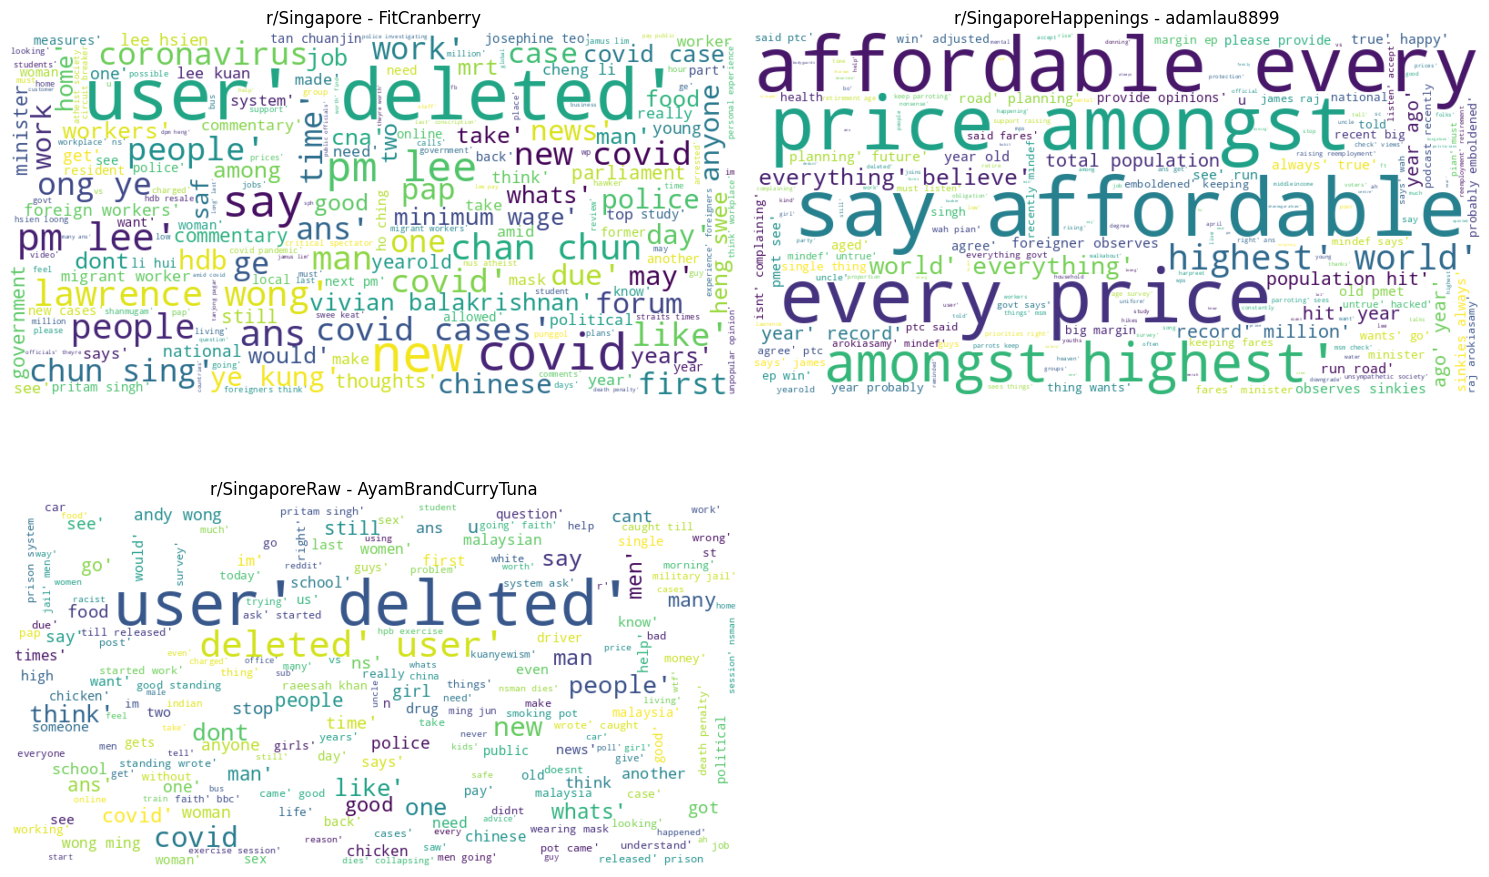

In [11]:
# Ensure 'post_title' is of string type
Data['post_title'] = Data['post_title'].astype(str)

# Apply filtering conditions to keep specific rows in Data
filtered_data = Data[
    (Data['username'] != '[deleted]') &
    (Data['username'] != 'sneakpeek_bot') &
    ~Data['post_title'].str.startswith('/r/singapore random discussion and small questions thread for')
]

# Count the number of toxic comments by subreddit and username
toxic_counts = filtered_data[filtered_data['BERT_2_hate'] == True]
top_users = toxic_counts.groupby(['subreddit', 'username']).size().reset_index(name='toxic_comments')

# Find the username with the most toxic comments for each subreddit
top_users = top_users.loc[top_users.groupby('subreddit')['toxic_comments'].idxmax()]

# Generate the word cloud for toxic comments using their RAKE keywords
unique_subreddits = top_users['subreddit'].unique()
num_subreddits = len(unique_subreddits)

# Determine the number of rows and columns for subplots
num_cols = 2  # Set the number of columns for subplots
num_rows = (num_subreddits // num_cols) + (num_subreddits % num_cols > 0)

plt.figure(figsize=(15, 5 * num_rows))

for i, (subreddit, username) in enumerate(zip(top_users['subreddit'], top_users['username'])):
    # Get the toxic comments for the top user in that subreddit
    user_toxic_comments = filtered_data[
        (filtered_data['username'] == username) &
        (filtered_data['subreddit'] == subreddit) &
        (filtered_data['BERT_2_hate'] == True)
    ]

    # Combine the RAKE keywords for the toxic comments
    rake_keywords_combined = ' '.join(user_toxic_comments['rake_keywords'].fillna(''))

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(rake_keywords_combined)

    # Plotting
    plt.subplot(num_rows, num_cols, i + 1)  # Adjust based on number of subreddits
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.title(f"{subreddit} - {username}")

plt.tight_layout()
plt.show()


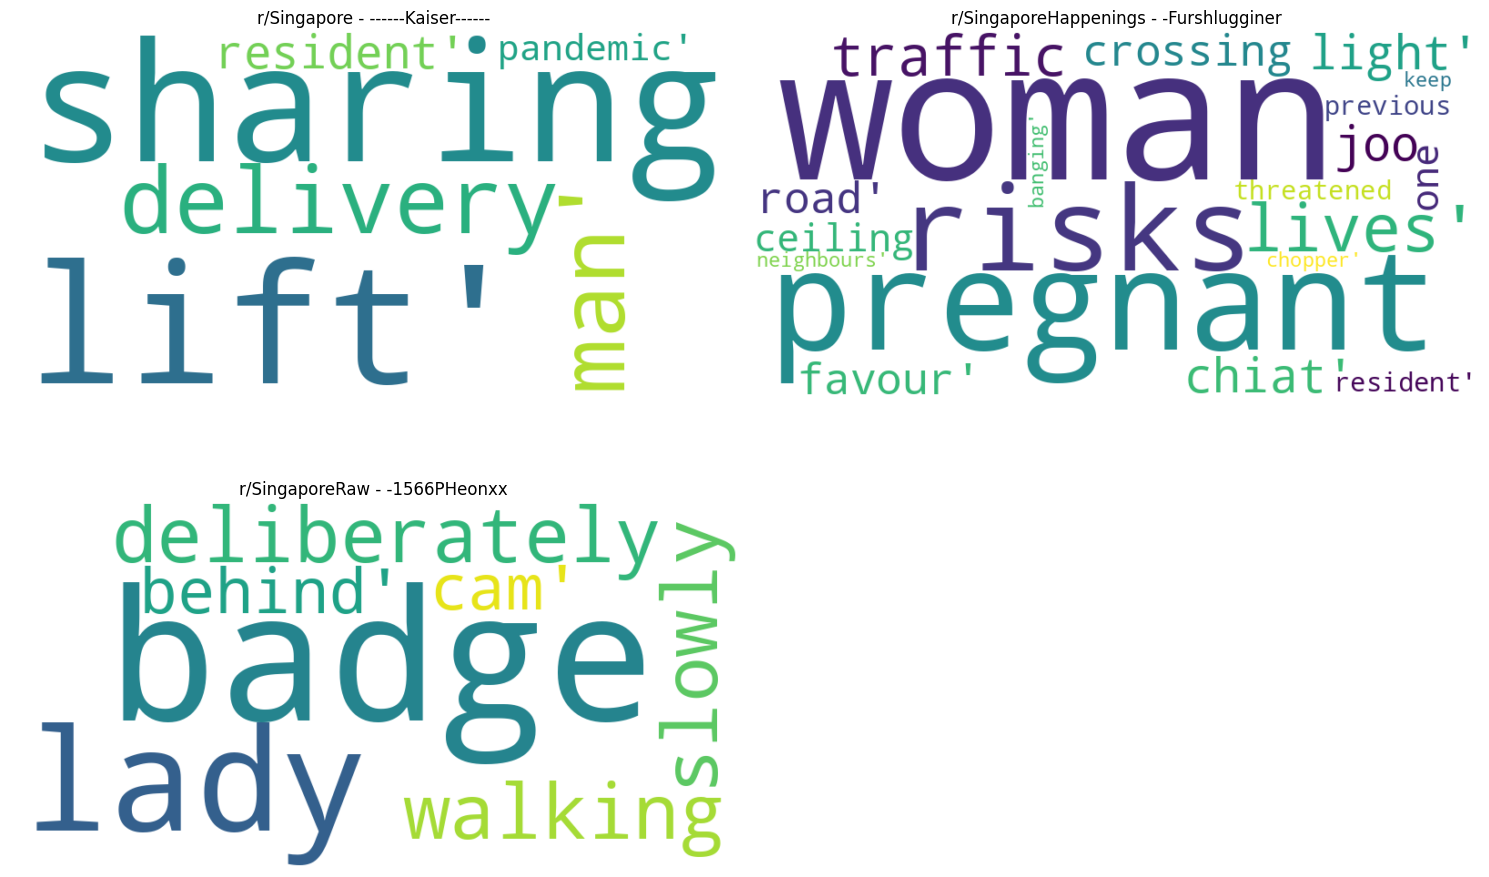

In [25]:
# Filter out unwanted usernames
filtered_data = Data[~Data['username'].isin(['[deleted]', 'sneakpeak_bot'])]

# Count total comments and hate comments for each username per subreddit
comment_counts = filtered_data.groupby(['subreddit', 'username']).size().reset_index(name='total_comments')
hate_counts = filtered_data[filtered_data['BERT_2_hate'] == True].groupby(['subreddit', 'username']).size().reset_index(name='hate_comments')

# Merge total comments and hate comments data
user_comment_stats = pd.merge(comment_counts, hate_counts, on=['subreddit', 'username'], how='left').fillna(0)

# Calculate the proportion of hate comments
user_comment_stats['proportion_hate'] = user_comment_stats['hate_comments'] / user_comment_stats['total_comments']

# Find the username with the highest proportion of hate comments for each subreddit
top_users_by_proportion = user_comment_stats.loc[user_comment_stats.groupby('subreddit')['proportion_hate'].idxmax()]

# Generate the word cloud for all comments using RAKE keywords for the identified users
unique_subreddits = top_users_by_proportion['subreddit'].unique()
num_subreddits = len(unique_subreddits)

# Determine the number of rows and columns for subplots
num_cols = 2  # Set the number of columns for subplots
num_rows = (num_subreddits // num_cols) + (num_subreddits % num_cols > 0)

plt.figure(figsize=(15, 5 * num_rows))

for i, (subreddit, username) in enumerate(zip(top_users_by_proportion['subreddit'], top_users_by_proportion['username'])):
    # Get all comments for the top user in that subreddit
    user_all_comments = filtered_data[
        (filtered_data['username'] == username) &
        (filtered_data['subreddit'] == subreddit)
    ]

    # Combine the RAKE keywords for all comments
    rake_keywords_combined = ' '.join(user_all_comments['rake_keywords'].fillna(''))

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(rake_keywords_combined)

    # Plotting
    plt.subplot(num_rows, num_cols, i + 1)  # Adjust based on number of subreddits
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.title(f"{subreddit} - {username}")

plt.tight_layout()
plt.show()

